# Transfer Learning with TensorFlow Part 2: Fine-tuning 👀

In [2]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Create helper functions

It a good idea to put functions you'll want to use again in a script you can download and import into your notebooks.

In [5]:
# Import helper function we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we'll see how we can use pretrained models. <br>
Within `tf.keras.applications` and apply tem to ourown problem. <br>
We qill use `10%` of food data.

In [7]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [9]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [10]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


> Using new way of ImageDataGenerator 🐼

In [12]:
# Check out the class names of our class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is stright-forward, it runs our layers in sequential order.

But thefunctional API gives more flexibility with our models.  🖥️

In [15]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained are not update during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="Input_layer")

# 4. If using a model like ResNet50V2 you need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to base model
x = base_model(inputs)
print(f"Shape after passing inputs hrough base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information)
x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePoolingLayers")(x)
print(f"Shape after GlobalAveragePooling: {x.shape}")

# 7. Create the output layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="Output_layer")(x)

# 8. Combine the imputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile a model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save the history
history_10_percent =  model_0.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.25*len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name="TransferLearning", experiment_name="10percnt_feature_extraction")]) #Validation only 25% for time saving 

Shape after passing inputs hrough base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling: (None, 1280)
Saving TensorBoard log files to: TransferLearning/10percnt_feature_extraction/20240208-162620


Epoch 1/5


2024-02-08 16:26:20.669713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [750]
	 [[{{node Placeholder/_0}}]]
2024-02-08 16:26:20.669933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [750]
	 [[{{node Placeholder/_4}}]]
2024-02-08 16:26:22.308193: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - ETA: 0s - loss: 1.8535 - accuracy: 0.4320

2024-02-08 16:26:29.079125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2500]
	 [[{{node Placeholder/_0}}]]
2024-02-08 16:26:29.079301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2500]
	 [[{{node Placeholder/_4}}]]


24/24 [==============================] - 14s 511ms/step - loss: 1.8535 - accuracy: 0.4320 - val_loss: 1.2965 - val_accuracy: 0.7138
Epoch 2/5
24/24 [==============================] - 11s 478ms/step - loss: 1.0843 - accuracy: 0.7760 - val_loss: 0.8802 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - 11s 482ms/step - loss: 0.7772 - accuracy: 0.8293 - val_loss: 0.7211 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 12s 487ms/step - loss: 0.6300 - accuracy: 0.8600 - val_loss: 0.6530 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 12s 483ms/step - loss: 0.5433 - accuracy: 0.8840 - val_loss: 0.5682 - val_accuracy: 0.8421


Epoch 1/5
24/24 [==============================] - 14s 511ms/step - loss: 1.8535 - accuracy: 0.4320 - val_loss: 1.2965 - val_accuracy: 0.7138 <br>
Epoch 2/5
24/24 [==============================] - 11s 478ms/step - loss: 1.0843 - accuracy: 0.7760 - val_loss: 0.8802 - val_accuracy: 0.7961 <br>
Epoch 3/5
24/24 [==============================] - 11s 482ms/step - loss: 0.7772 - accuracy: 0.8293 - val_loss: 0.7211 - val_accuracy: 0.8109 <br>
Epoch 4/5
24/24 [==============================] - 12s 487ms/step - loss: 0.6300 - accuracy: 0.8600 - val_loss: 0.6530 - val_accuracy: 0.8306 <br>
Epoch 5/5
24/24 [==============================] - 12s 483ms/step - loss: 0.5433 - accuracy: 0.8840 - val_loss: 0.5682 - val_accuracy: 0.8421 <br>

In [16]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 22s 278ms/step - loss: 0.5498 - accuracy: 0.8612


[0.5497676134109497, 0.8611999750137329]

In [17]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_3
1 rescaling_4
2 normalization_2
3 rescaling_5
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [19]:
# How about we get a sunmmary of our base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                   

In [20]:
# How about of our model?
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePoolingLayers   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 Output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


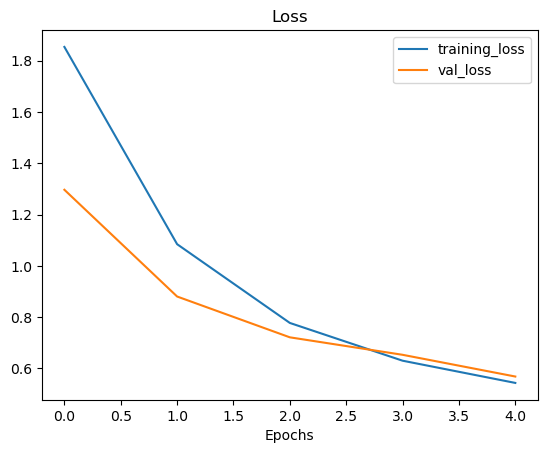

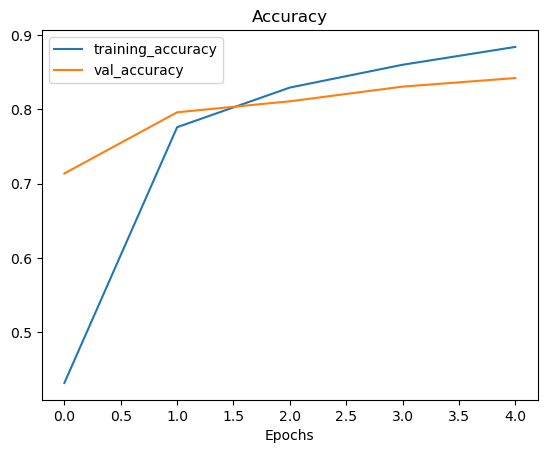

In [21]:
# Check out our model training curves
plot_loss_curves(history=history_10_percent)